In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/yuncong/Brain/pipeline_scripts')
import utilities2014
reload(utilities2014)
from utilities2014 import *

import os

# os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
# os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
# os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/csd395/DavidData2014results/'
# os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from networkx import floyd_warshall, Graph, connected_components, draw_networkx, k_clique_communities, find_cliques, from_numpy_matrix
from itertools import product
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
stack_name = 'RS141'

In [220]:
# dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=7)
# m = dm.load_pipeline_result('matchings%dWith%d'%(7, 8), 'pkl')
# d = dm.load_pipeline_result('DBoundaries%dWith%d'%(7, 8), 'npy')
# d_shape = dm.load_pipeline_result('D3s%dWith%d'%(7, 8), 'npy')

In [221]:
# def get_relaxed_matches(D, dist_percent_thresh=.2):
#     nns1 = D.argsort(axis=1)[:,:3]
#     nns2 = D.argsort(axis=0)[:3,:].T

#     dd = D[D!=np.inf]
#     th = np.sort(dd)[int(dist_percent_thresh*len(dd))]

#     relaxed_matches = [(i,n) for i, nns in enumerate(nns1) for n in nns if i in nns2[n] and D[i,n] < th]

#     return relaxed_matches

In [222]:
# print get_relaxed_matches(d)

In [6]:
from subprocess import check_output
s = check_output("ssh gordon.sdsc.edu ls %s" % os.path.join(os.environ['GORDON_DATA_DIR'], stack_name, 'x5'), shell=True)
slide_indices = [int(f) for f in s.split('\n') if len(f) > 0]
n_slice = len(slide_indices)
last_sec = max(slide_indices)

In [7]:
G = Graph()

for sec1 in slide_indices:
    dm1 = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec1)
    
    if sec1 < last_sec:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec1+1), 'pkl')
        for s,i,j in matchings:
            G.add_edge((sec1,i),(sec1+1,j))

    if sec1 < last_sec-1:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec1+2), 'pkl')
        for s,i,j in matchings:
            G.add_edge((sec1,i),(sec1+2,j))
    
    if sec1 < last_sec-2:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec1+3), 'pkl')
        for s,i,j in matchings:
            G.add_edge((sec1,i),(sec1+3,j))

In [8]:
# G = Graph()

# th = .2

# for sec1 in range(0,29):
#     dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec1)
    
#     D = dm.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec1+1), 'npy')
#     relaxed_matches = get_relaxed_matches(D, th)
    
#     for i,j in relaxed_matches:
#         G.add_edge((sec1,i),(sec1+1,j))

#     if sec1 < 28:
#         D = dm.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec1+2), 'npy')
         
#         relaxed_matches = get_relaxed_matches(D, th)
        
#         for i,j in relaxed_matches:
#             G.add_edge((sec1,i),(sec1+2,j))
    
#     if sec1 < 27:
#         D = dm.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec1+3), 'npy')
        
#         relaxed_matches = get_relaxed_matches(D, th)
        
#         for i,j in relaxed_matches:
#             G.add_edge((sec1,i),(sec1+3,j))
            

In [9]:
pos = {}
for s,l in G.node:
    pos[(s,l)] = (s,l)

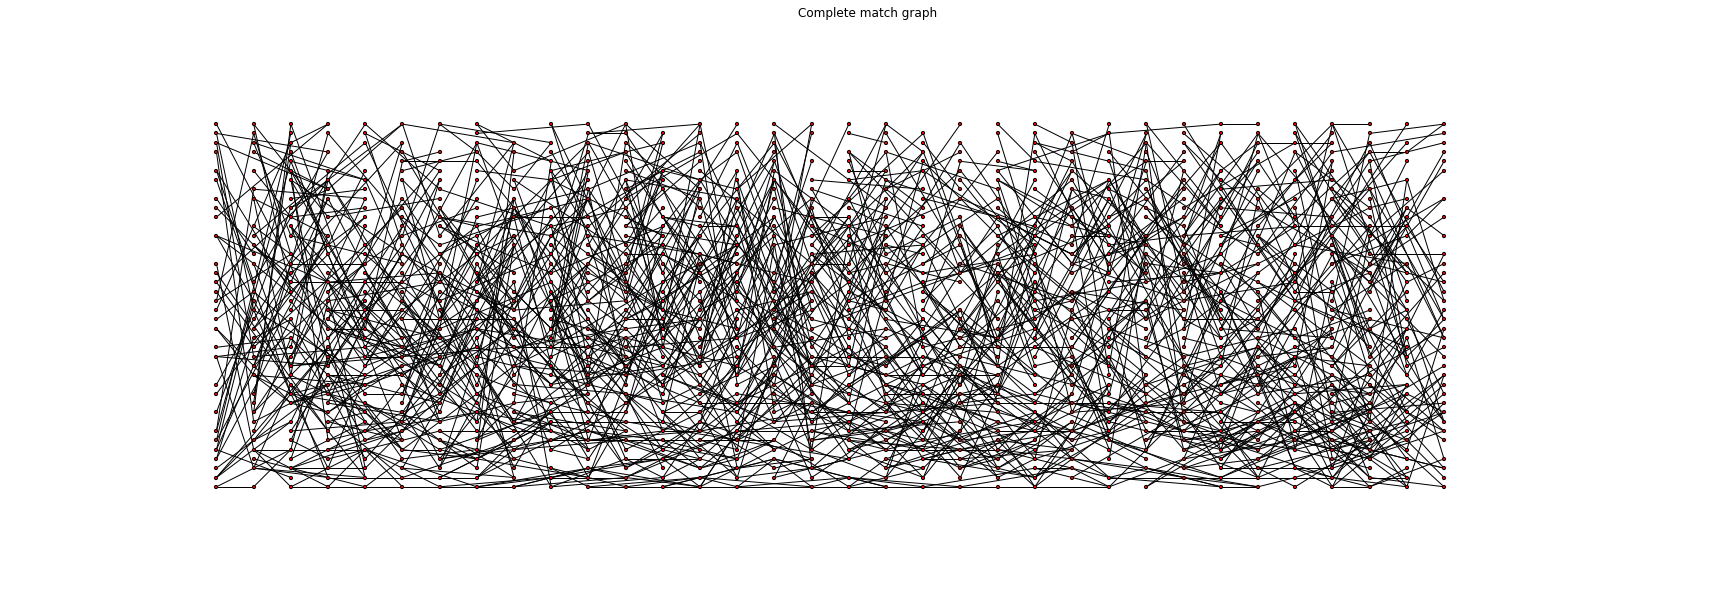

In [14]:
fig = plt.figure(figsize=(30,10));
plt.axis('off');
plt.title('Complete match graph');
# draw_networkx(G, pos, node_size=10, with_labels=False, edgelist=[]);
draw_networkx(G, pos, node_size=10, with_labels=False);

In [15]:
from scipy.cluster.hierarchy import average, fcluster, single, complete, weighted
from scipy.spatial.distance import cdist, pdist, squareform

def group_clusters(distance_matrix, dist_thresh = 0.1):

    lk = single(squareform(distance_matrix))
#     lk = average(squareform(distance_matrix))
#     lk = complete(squareform(distance_matrix))

    T = fcluster(lk, dist_thresh, criterion='distance')
    
    n_groups = len(set(T))    
    groups = [None] * n_groups

    for group_id in range(n_groups):
        groups[group_id] = np.where(T == group_id+1)[0]
        
    return [g for g in groups if len(g) > 0]

In [16]:
def draw_group_containing_node(node, node_groups):
        
    group_lookup = defaultdict(set)
    for gi, g in enumerate(node_groups):
        for n in g:
            group_lookup[n].add(gi)
    
    group_ind = list(group_lookup[node])[0]
        
    fig = plt.figure(figsize=(30,10));
    plt.axis('off');

    # draw_networkx(G, pos, node_size=10, with_labels=False)
    # plt.savefig('/tmp/match_graph_relaxed.png', bbox_inches='tight')

    # draw_networkx(G, pos, node_size=10, with_labels=False, edge_color=colors)

    selected_edges = [(i,j) for i,j in G.edges_iter() 
                      if i in group_lookup and j in group_lookup and group_ind in group_lookup[i]
                     and group_ind in group_lookup[j]]
        
#     selected_colors = [all_colors[group_lookup[i]%len(all_colors)] for i,j in G.edges_iter() 
#                        if i in group_lookup and j in group_lookup and group_lookup[i] == group_ind]
    
#     selected_nodes = set([i for e in selected_edges for i in e ]) | set(node_groups[group_ind])
    selected_nodes = set([i for e in selected_edges for i in e ])
    node_size = [50 if n in selected_nodes else 5 for n in G.nodes_iter()]

    draw_networkx(G, pos, with_labels=False, edgelist=selected_edges, edge_color='r',
                 node_size=node_size)
    # plt.savefig('/tmp/clique_groups_relaxed.png', bbox_inches='tight')
    
    return sorted(list(selected_nodes))
            

In [17]:
node = (9,7)

[(6, 1), (7, 1), (8, 5), (9, 7), (10, 7), (11, 7), (12, 7)]

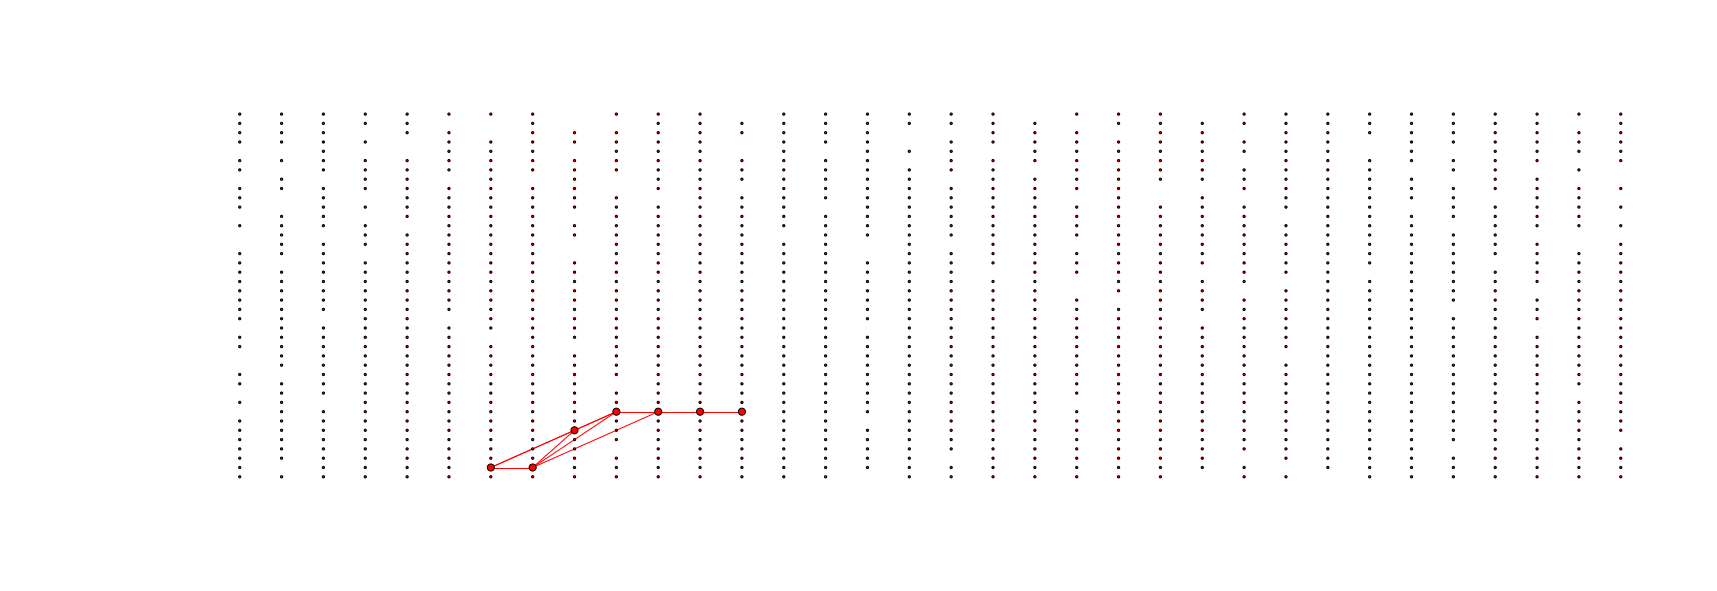

In [18]:
draw_group_containing_node(node, [set(G.neighbors(node)) | {node}])

In [19]:
# cliques = sorted([sorted(cl) for cl in find_cliques(G) if len(cl)>=3], key=len, reverse=True)
# cliques = [set(cl)for cl in find_cliques(G) if len(cl) == 4]
cliques = [set(cl)for cl in find_cliques(G) if len(cl) >= 3]
overlap_mat = np.reshape([len(i & j) for i,j in product(cliques,cliques)], (len(cliques),len(cliques)))

m = overlap_mat.max()
d = m - overlap_mat
np.fill_diagonal(d, 0)

# node_groups = list(k_clique_communities(G, 4))
# draw_group_containing_node(node, node_groups)

overlap_thresh = 2
node_groups = sorted([sorted(list(set(sum([list(cliques[i]) for i in g], [])))) 
               for g in group_clusters(d, m-overlap_thresh)], 
                     key=len, reverse=True)

# h = draw_group_containing_node(node, node_groups)

# overlap_thresh = 1
# node_groups = sorted([sorted(list(set(sum([list(cliques[i]) for i in g], [])))) 
#                for g in group_clusters(d, m-overlap_thresh)], 
#                      key=len, reverse=True)

# h = draw_group_containing_node(node, node_groups)

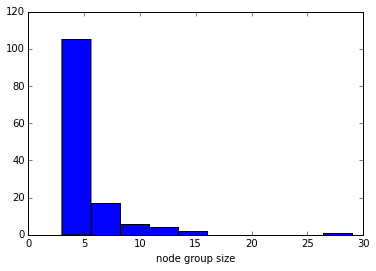

In [20]:
plt.hist([len(g) for g in node_groups if len(g) >= 2]);
plt.xlabel('node group size');
plt.show();

[(9, 7), (10, 7), (11, 7), (12, 7)]

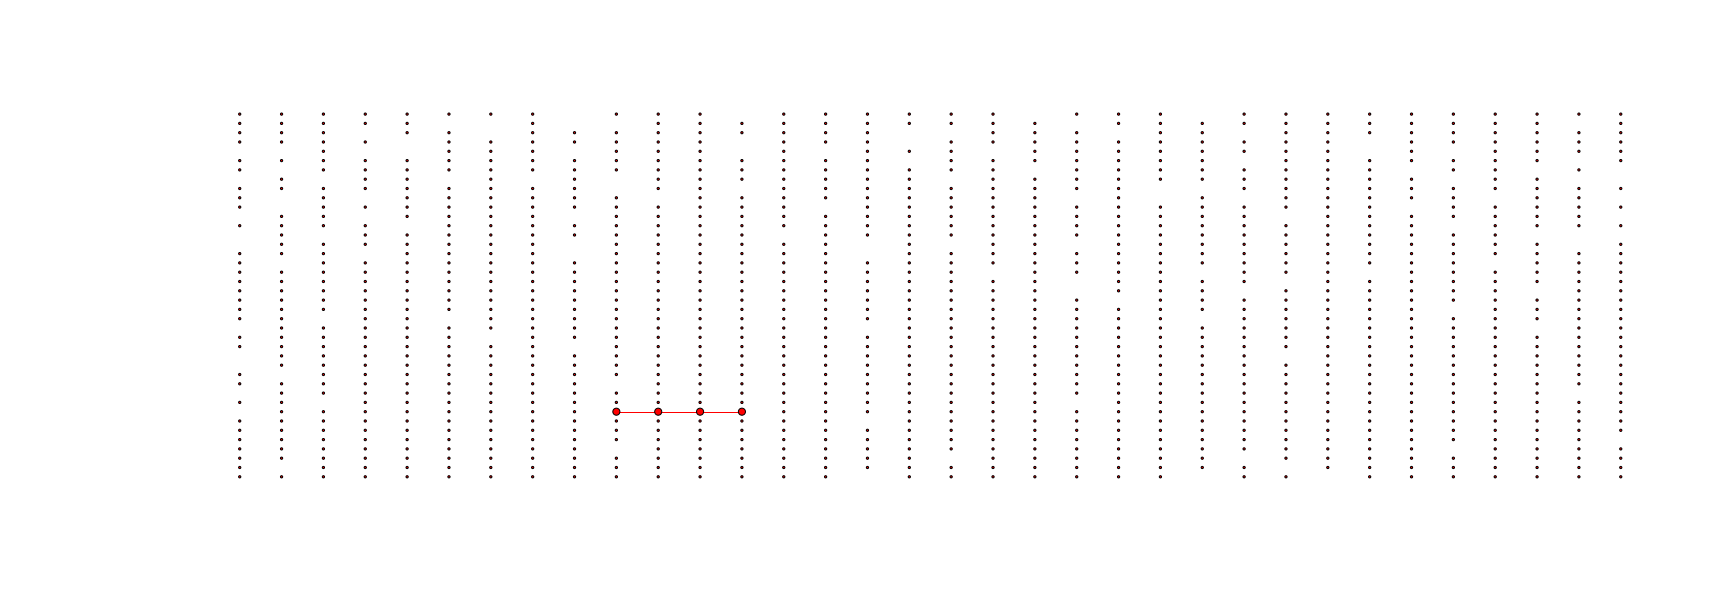

In [21]:
draw_group_containing_node(node, cliques)

In [22]:
from skimage.util import pad

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

def visualize_landmark_multiple_sections2(tpl, text=False):
    '''
    e.g. tpl = [(3,1),(4,2)]
    '''
    
    viss = []
    for sec, bnd in tpl: 
        dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec)
        v = dm.load_pipeline_result('boundary%02d'%bnd, 'jpg')
        if text:
            cv2.putText(v, '%d,%d'%(sec,bnd), tuple([300,300]), cv2.FONT_HERSHEY_COMPLEX, 10, (0,0,0), 5)
        viss.append(v)
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    top_margins = [int((hmax - h)/2) for h,w in hws]
    bottom_margins = [ hmax - h - lm for (h,w), lm in zip(hws, top_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, top_margins, bottom_margins):
        viss_padded.append(pad(vis, ((lm,rm),(0,0),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.hstack(viss_padded)
    return vis_stacked

In [23]:
def rigid_transform_from_pairs(X,Y):
    '''
    X, Y are n-by-2 matrices
    Reference: http://nghiaho.com/?page_id=671
    '''

    n = X.shape[0]
    assert X.shape[0] == Y.shape[0], 'two point sets have different size'
    assert n >= 2, 'rgiid transform estimate needs at least two points'
    
    X = X.T
    Y = Y.T
    
    Xcentroid = X.mean(axis=1)
    Ycentroid = Y.mean(axis=1)
    
    Xcentered = X - Xcentroid[:, np.newaxis]
    Ycentered = Y - Ycentroid[:, np.newaxis]
    
    U, S, V = np.linalg.svd(np.dot(Xcentered, Ycentered.T))
    R = np.dot(V, U.T)
    d = np.linalg.det(R)
    if d < 0:
        R[1] *= -1
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid - np.dot(R, Xcentroid)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
#     pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans[:,:2]

In [24]:
good_node_groups = [g for g in node_groups if len(g) >= 5]
# good_node_groups = node_groups

In [25]:
dms = [ DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec_ind) 
       for sec_ind in slide_indices]

In [26]:
for dm in dms:
    dm._load_image()
    
boundary_models = [dm.load_pipeline_result('boundaryModels', 'pkl') for dm in dms]

In [234]:
d = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5')
d.save_pipeline_result(good_node_groups, 'landmarkGroups', 'pkl')

saved /home/yuncong/csd395/DavidData2014results/RS141/RS141_x5_gabor-blueNisslWide-vq-blueNissl_landmarkGroups.pkl


In [27]:
section_contains = [[] for _ in range(n_slice)]
for nid, ns in enumerate(good_node_groups):
    for sec, lm_ind in ns:
        section_contains[sec].append((lm_ind, nid))

In [28]:
section_contains_centroids = [dict([(gid, boundary_models[si][bid][4]) for bid, gid in sc]) 
                              for si, sc in enumerate(section_contains)]

In [29]:
gid_overlap = [[set(sc1.keys()) & set(sc2.keys()) for sc2 in section_contains_centroids] for sc1 in section_contains_centroids]

In [30]:
import random

def ransac_rigid_transform(X, Y, sample_size=3):
    
    n = X.shape[0]
    err_all = []
    T_all = []
    inlier_all = []
    for si in range(10):    
#         print 'iter', si
        s = random.sample(range(n), min(sample_size, n))
        for ri in range(10):
            Xs = X[s]
            Ys = Y[s]
            T, _ = rigid_transform_from_pairs(Xs, Ys)
            Xst = rigid_transform_to(Xs, T)
            d = Xst - Ys
            errs = np.sqrt(np.sum(d**2, axis=1))
            s2 = list(set(s) | set(np.where(errs < 500)[0]))
#             print ri, np.mean(errs), len(s2)
            if len(s2) == len(s):
                break
            else:
                s = s2
        inlier_all.append(s)
        err_all.append(np.mean(errs))
        T_all.append(T)
    
    best = np.argmin(err_all)
#     print err_all[best]
#     print best
    return T_all[best], inlier_all[best]

In [31]:
margin = 500

img_shapes = [dm.image_rgb.shape[:2] for dm in dms]
max_height, max_width = np.max(img_shapes, axis=0)

canvas_width = max_width + 2 * margin
canvas_height = max_height + 2 * margin

In [51]:
def pad_image(img, canvas_shape):
    
    canvas_height, canvas_width = canvas_shape
    
    bg = 255 * np.ones((canvas_height, canvas_width, 3), dtype=np.uint8)
    rgb = img[..., :3]

    img_h, img_w = img.shape[:2]
    bg[canvas_height/2-img_h/2:canvas_height/2+(img_h-img_h/2),
            canvas_width/2-img_w/2:canvas_width/2+(img_w-img_w/2), :] = rgb

    return bg

In [52]:
for dm in dms:
    atlas_img = dm.load_pipeline_result('atlas', 'jpg')
    padded_img = pad_image(atlas_img, (canvas_height, canvas_width))
    dm.save_pipeline_result(padded_img, 'paddedGlobalLabel', 'jpg')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0000/RS141_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_paddedGlobalLabel.jpg
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_paddedGlobalLabel.jpg
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0002/RS141_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_paddedGlobalLabel.jpg
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0003/RS141_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_paddedGlobalLabel.jpg
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_paddedGlobalLabel.jpg
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0005/RS141_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_paddedGlobalLabel.jpg
saved /oasis/pro

In [159]:
for dm in dms:
    padded_img = pad_image(dm.image_rgb, (canvas_height, canvas_width))
    dm.save_pipeline_result(padded_img, 'padded', 'jpg')

saved /home/yuncong/csd395/DavidData2014results/RS141/0000/RS141_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_padded.jpg
saved /home/yuncong/csd395/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_padded.jpg
saved /home/yuncong/csd395/DavidData2014results/RS141/0002/RS141_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_padded.jpg
saved /home/yuncong/csd395/DavidData2014results/RS141/0003/RS141_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_padded.jpg
saved /home/yuncong/csd395/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_padded.jpg
saved /home/yuncong/csd395/DavidData2014results/RS141/0005/RS141_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_padded.jpg
saved /home/yuncong/csd395/DavidData2014results/RS141/0006/RS141_x5_0006_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_padded.jpg
saved /home/yuncong/csd395/

In [35]:
spacings_yx = np.array([((canvas_height-h)/2, (canvas_width-w)/2) for h,w in img_shapes])

In [36]:
undetermined_section_pairs = zip(*map(list, np.where([[len(gids) < 2 for gids in g] for g in gid_overlap])))

In [37]:
Ts = np.empty((n_slice, n_slice, 3, 3))
# angles = np.empty((n_slice, n_slice))
Xs = [[None for _ in range(n_slice)] for _ in range(n_slice)]
Xts = [[None for _ in range(n_slice)] for _ in range(n_slice)]
Ys = [[None for _ in range(n_slice)] for _ in range(n_slice)]

for s1, a in enumerate(gid_overlap):
    for s2, gids in enumerate(a):
        if (s1,s2) in undetermined_section_pairs or (s2,s1) in undetermined_section_pairs:
            Ts[s1,s2] = np.nan * np.ones((3,3))
        else:
            gids = list(gids)
            X = np.array([section_contains_centroids[s1][gid] + spacings_yx[s1][::-1] for gid in gids])
            Y = np.array([section_contains_centroids[s2][gid] + spacings_yx[s2][::-1] for gid in gids])
            Xs[s1][s2] = X
            Ys[s1][s2] = Y
            
#             T, _ = rigid_transform_from_pairs(X, Y)
            T, inliers = ransac_rigid_transform(X, Y)
#             print [gids[i] for i in inliers]
            
            Xt = rigid_transform_to(X, T)
            Xts[s1][s2] = Xt
            Ts[s1,s2] = T
#             angles[s1,s2] = angle

#             plt.title('%d,%d'%(s1,s2))
# #             gids = list(gid_overlap[s1][s2])
#             if len(gids) <= 1:
#                 continue

#             plt.scatter(Xts[s1][s2][:,0], Xts[s1][s2][:,1], c='r');
#             plt.scatter(Ys[s1][s2][:,0], Ys[s1][s2][:,1], c='g');
#             for i, gid in enumerate(gids):
#                 plt.text(Xts[s1][s2][i,0], Xts[s1][s2][i,1], str(gid));
#                 plt.text(Ys[s1][s2][i,0], Ys[s1][s2][i,1], str(gid));

#             plt.ylim([0, dms[s2].image_rgb.shape[0]])
#             plt.xlim([0, dms[s2].image_rgb.shape[1]])

#             plt.axis('equal');
#             plt.show();

IndexError: list index out of range

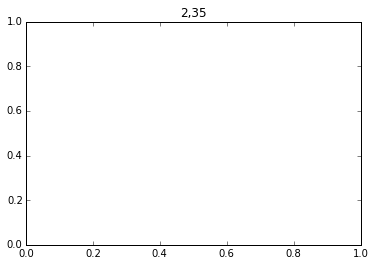

In [38]:
s1 = 2
s2 = 35

plt.title('%d,%d'%(s1,s2))
gids = list(gid_overlap[s1][s2])
assert  len(gids) > 1
    
plt.scatter(Xts[s1][s2][:,0], Xts[s1][s2][:,1], c='r');
plt.scatter(Ys[s1][s2][:,0], Ys[s1][s2][:,1], c='g');
for i, gid in enumerate(gids):
    plt.text(Xts[s1][s2][i,0], Xts[s1][s2][i,1], str(gid));
    plt.text(Ys[s1][s2][i,0], Ys[s1][s2][i,1], str(gid));

plt.gca().set_ylim([0, canvas_height])
plt.gca().set_xlim([0, canvas_width])

# plt.ylim([0, dms[s2].image_rgb.shape[0]])
# plt.xlim([0, dms[s2].image_rgb.shape[1]])

plt.axis('equal');
plt.show();

In [39]:
Rs = Ts[..., :2, :2]
angles = np.arctan2(Rs[..., 1,0], Rs[...,0,0])

In [40]:
ts = np.zeros((n_slice, n_slice, 2))
for sc1 in range(n_slice):
    for sc2 in range(n_slice):
        ts[sc1, sc2] = np.dot(np.linalg.inv(Rs[sc1,sc2]), Ts[sc1,sc2,:2,2])

In [41]:
rs,cs = np.triu_indices(n_slice,1)
valid_section_pairs = list(set(zip(rs.tolist(), cs.tolist())) - set(undetermined_section_pairs))

weights = np.array([np.exp(-(np.abs(i-j)-1)) for i,j in valid_section_pairs])

nc = len(valid_section_pairs)

A = np.zeros((nc, n_slice))
for r, (i,j) in enumerate(valid_section_pairs):
    A[r, [i,j]] = np.array([1, -1])

rs, cs = zip(*valid_section_pairs)
b = ts[rs,cs]

In [42]:
t0 = np.dot(np.linalg.pinv(weights[:,np.newaxis] * A), weights[:,np.newaxis] * b)

In [43]:
print t0[16]-t0[17]
print ts[16,17]

[ -517.91318184  1010.7473646 ]
[-513.08872707  992.33135286]


In [44]:
A = np.zeros((nc, n_slice))
for r, (i,j) in enumerate(valid_section_pairs):
    A[r, [i,j]] = [1, -1]

rs, cs = zip(*valid_section_pairs)
b = angles[rs,cs]

In [45]:
angles0 = np.dot(np.linalg.pinv(weights[:,np.newaxis] * A),  weights * b)
R0s = [np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]]) for a in angles0]

In [46]:
def rot_to_angle(R):
    return np.rad2deg(np.arctan2(R[1,0], R[0,0]))

In [47]:
print np.rad2deg(angles[16,17])
print rot_to_angle(R0s[16]) - rot_to_angle(R0s[17])

-19.9636114474
-20.0981575507


In [48]:
T0s = [np.vstack([np.column_stack([R, np.dot(R, t0[i])]), [0,0,1]]) for i, R in enumerate(R0s)]

In [53]:
from skimage.transform import warp, AffineTransform

for sc, dm in enumerate(dms):
    print sc
#     padded_img = dm.load_pipeline_result('padded', 'jpg')
    padded_img = dm.load_pipeline_result('paddedGlobalLabel', 'jpg')
    trf = AffineTransform(T0s[sc])
    img_trf = warp(padded_img, inverse_map=trf.inverse)
    dm.save_pipeline_result(img_trf, 'alignedGlobalLabel', 'jpg')

0
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0000/RS141_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_alignedGlobalLabel.jpg
1
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_alignedGlobalLabel.jpg
2
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0002/RS141_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_alignedGlobalLabel.jpg
3
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0003/RS141_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_alignedGlobalLabel.jpg
4
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_alignedGlobalLabel.jpg
5
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0005/RS141_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_alignedGlobalLabel.jp

In [55]:
# for sc1 in range(n_slice):
#     imsave('/tmp/Orig%02d.jpg'%sc1, padded_imgs[sc1])

In [1005]:
# from skimage.transform import warp, AffineTransform

# # for sc1 in range(n_slice):
# #     for sc2 in range(sc1+1, n_slice):
# sc1 = 16
# sc2 = 17
# #         print sc1, sc2
# # if np.any(np.isnan(Ts[sc1, sc2])):
# #     continue

# trf = AffineTransform(Ts[sc1, sc2])
# img_trf = warp(padded_imgs[sc1], inverse_map=trf.inverse)
# #         display(img_trf)

# img_trf_fn = '/tmp/%02dTo%02d.jpg'%(sc1, sc2)
# img_target_fn = '/tmp/Orig%02d.jpg'%sc2
# img_multilayer_fn = '/tmp/%02dTo%02d.tif'%(sc1, sc2)

# imsave(img_trf_fn, img_trf)
# os.system('convert %s %s %s' % (img_trf_fn, img_target_fn, img_multilayer_fn))

0

In [59]:
def generate_atlas_visualization(d):
    '''
    e.g. tpl = {section#:[(boundary#, landmark#),...], ...}
    '''
    
    for sec, bnds in d.iteritems():
        print sec, bnds
        dm = dms[sec]
        boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')
        viz = dm.visualize_edge_sets([boundaries[b[0]][0] for b in bnds], text_size=3, 
                                           text=[str(b[1]) for b in bnds])
        dm.save_pipeline_result(viz, 'atlas', 'jpg')

In [60]:
generate_atlas_visualization(dict(enumerate(section_contains)))

0 [(27, 1), (17, 23)]
saved /home/yuncong/csd395/DavidData2014results/RS141/0000/RS141_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_atlas.jpg
1 [(4, 0), (24, 1), (2, 2), (12, 23)]
saved /home/yuncong/csd395/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_atlas.jpg
2 [(0, 0), (13, 1), (11, 2), (16, 6), (28, 15), (9, 23)]
saved /home/yuncong/csd395/DavidData2014results/RS141/0002/RS141_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_atlas.jpg
3 [(0, 0), (22, 1), (1, 2), (10, 6), (17, 15), (8, 23), (12, 31)]
saved /home/yuncong/csd395/DavidData2014results/RS141/0003/RS141_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_atlas.jpg
4 [(4, 0), (14, 1), (1, 2), (6, 4), (9, 6), (16, 15), (17, 15), (11, 23), (23, 30), (5, 31)]
saved /home/yuncong/csd395/DavidData2014results/RS141/0004/RS141_x5_0004_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_atlas.jpg
5 [(0, 0), (14, 1), (1, 2), (11, 4

In [44]:
from joblib import Parallel, delayed
from skimage.transform import resize

def f(i, h):
    row_size = 5
    for r in np.arange(0, len(h), row_size):
        v = visualize_landmark_multiple_sections2(h[r:r+row_size], text=True)
        imsave('/tmp/robustLandmark%d_%d.jpg'%(i, r/row_size), resize(v, (v.shape[0]/5,v.shape[1]/5)))
        
Parallel(n_jobs=16)(delayed(f)(i, lms) for i, lms in enumerate(node_groups[:10]))  

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
# KMeans method using neighbor set as feature and Jaccard as distance

In [786]:
n_nodes = G.number_of_nodes()
connection_features = [set(G.neighbors(n)) | {n} for n in G.nodes_iter()]
overlap_mat = np.reshape([len(i&j)
                          for i,j in product(connection_features,connection_features)], 
                         (n_nodes,n_nodes))
m = overlap_mat.max()
d = m - overlap_mat
np.fill_diagonal(d, 0)

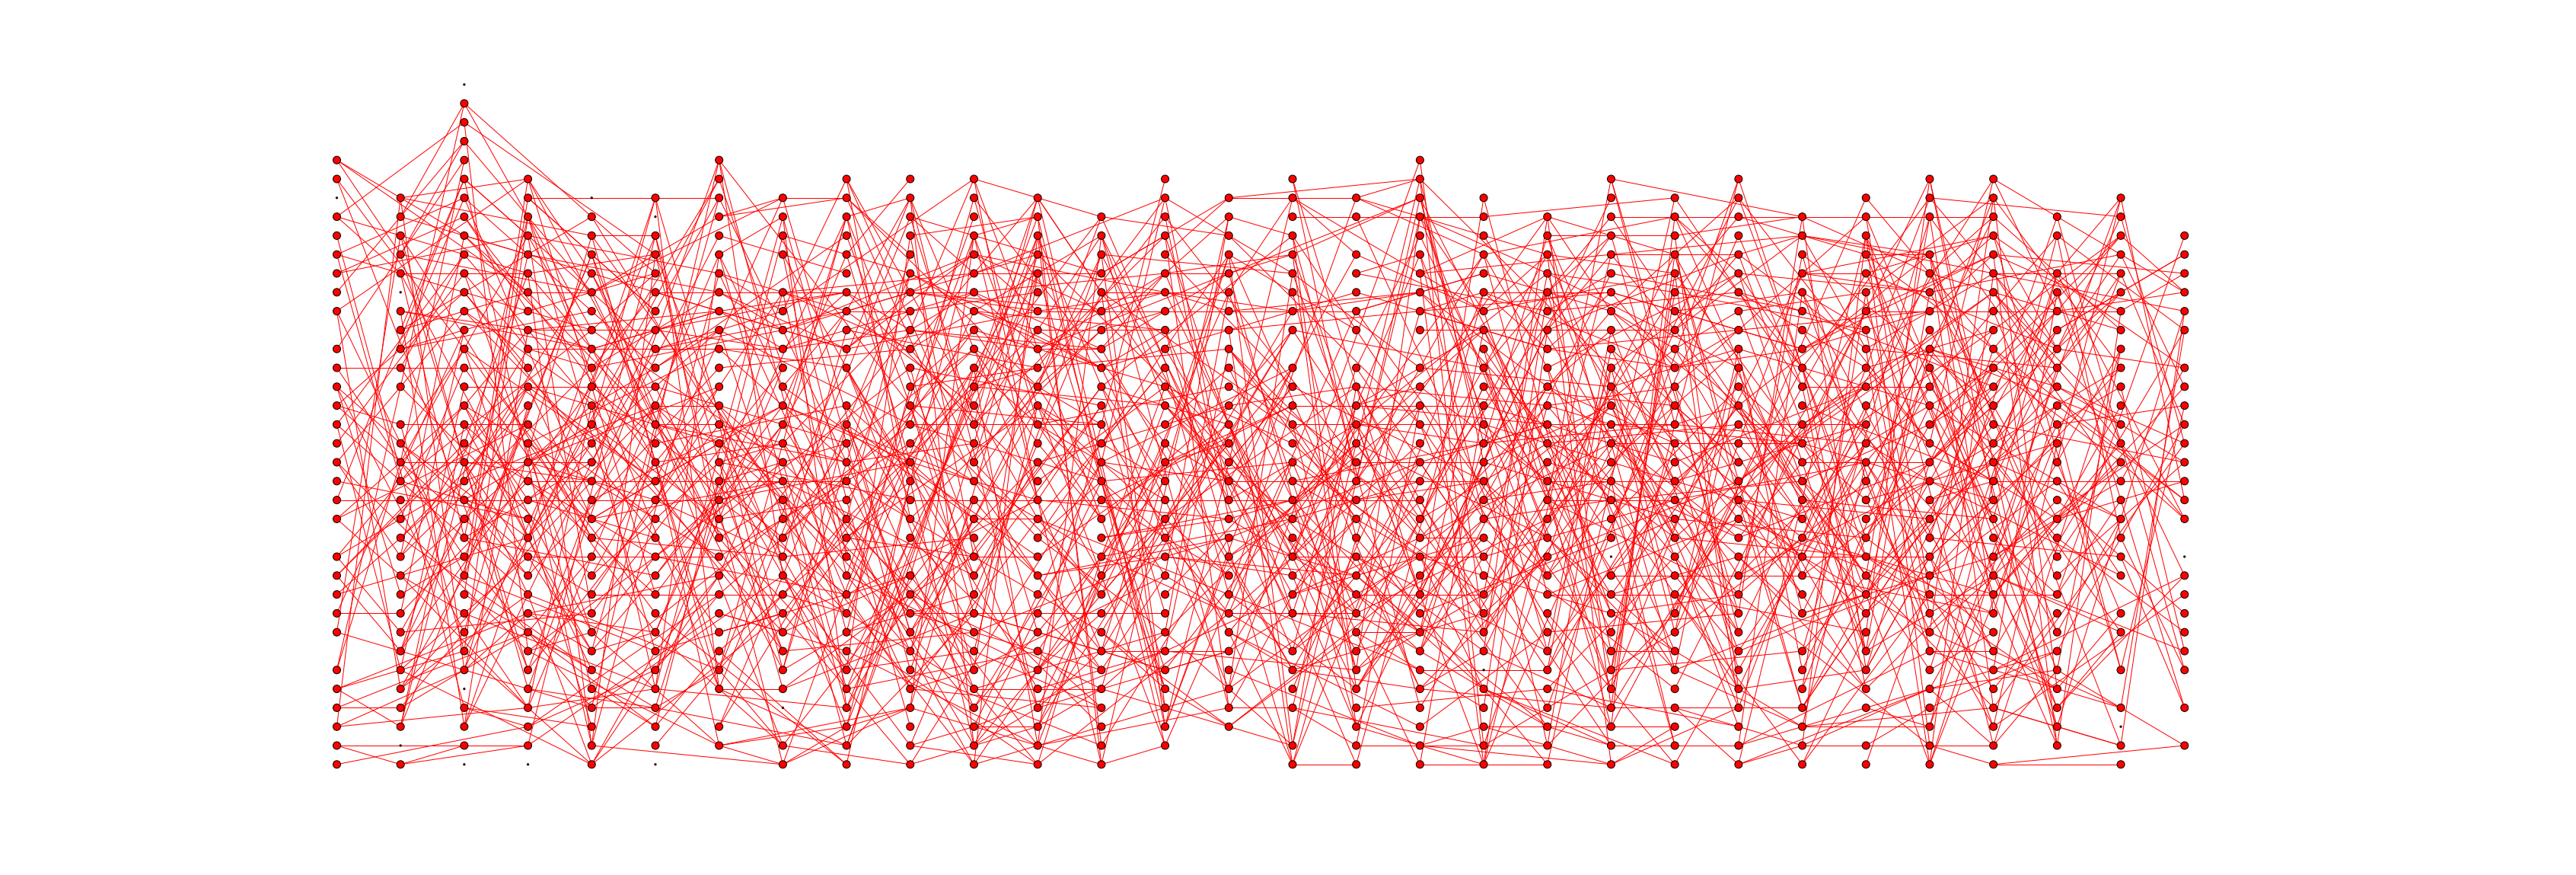

In [788]:
overlap_thresh = 1
node_groups = sorted([sorted([G.nodes()[n] for n in g]) 
                      for g in group_clusters(d, m-overlap_thresh)],
                     key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)

In [892]:
n_nodes = G.number_of_nodes()
connection_features = [set(G.neighbors(n)) | {n} for n in G.nodes_iter()]

jaccard_mat = np.zeros((n_nodes,n_nodes))
for i, (si, li) in enumerate(G.nodes_iter()):
    for j, (sj, lj) in enumerate(G.nodes_iter()):
        a = set([(sn,ln) for sn,ln in connection_features[i] if sn >= sj-3 and sn <= sj+3])
        b = set([(sn,ln) for sn,ln in connection_features[j] if sn >= si-3 and sn <= si+3])
        if len(a)==0 or len(b)==0:
            jaccard_mat[i,j] = 0
        else:
            jaccard_mat[i,j] = len(a&b)/float(len(a|b))

            
# jaccard_mat = np.reshape([len(i&j)/float(len(i|j)) 
#                           for i,j in product(connection_features,connection_features)], 
#                          (n_nodes,n_nodes))

In [ ]:
jaccard_thresh = .5
node_groups = sorted([sorted([G.nodes()[n] for n in g]) for g in group_clusters(1.-jaccard_mat, 1.-jaccard_thresh)],
                    key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)

jaccard_thresh = .6
node_groups = sorted([sorted([G.nodes()[n] for n in g]) for g in group_clusters(1.-jaccard_mat, 1.-jaccard_thresh)],
                    key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)

jaccard_thresh = .7
node_groups = sorted([sorted([G.nodes()[n] for n in g]) for g in group_clusters(1.-jaccard_mat, 1.-jaccard_thresh)],
                    key=lambda x: len(x), reverse=True)
draw_group_containing_node(node, node_groups)


node_groups = list(k_clique_communities(G, 4))
draw_group_containing_node(node, node_groups)


In [693]:
all_matchings = G.edges()

for i in all_matchings:
    if (2, 31) in i:
        print i

((0, 14), (2, 31))
((4, 7), (2, 31))
((5, 27), (2, 31))
((4, 1), (2, 31))
((4, 10), (2, 31))
((5, 11), (2, 31))
((3, 28), (2, 31))
((1, 20), (2, 31))
((0, 29), (2, 31))
((2, 31), (1, 23))
((2, 31), (5, 22))


In [72]:
from joblib import Parallel, delayed
from skimage.transform import resize

def f(i, lms):
    v = visualize_landmark_multiple_sections(lms, text=True)
    try:
        imsave('/tmp/robustLandmark%d.jpg'%i, v)
    except IOError as e:
        imsave('/tmp/robustLandmark%d.jpg'%i, resize(v, (v.shape[0]/2,v.shape[1]/2)))
        

Parallel(n_jobs=16)(delayed(f)(i, lms) for i, lms in enumerate(consistent_robust_lms))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [60]:
display(visualize_landmark_multiple_sections(robust_lms[5], text=True))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [38]:
display(visualize_multiple_landmarks_multiple_sections({2:[15], 3:[20]}))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [42]:
def visualize_multiple_landmarks_multiple_sections_horizontal(d):
    '''
    e.g. tpl = {3:[2,5,12], 4:[6,4,2]}
    '''
    
    viss = []
    for sec, bnds in d.iteritems():
        dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec)
        boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')
        viss.append(dm.visualize_edge_sets([boundaries[b[0]][0] for b in bnds], text_size=3, 
                                           text=[str(b[1]) for b in bnds]))
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    top_margins = [int((hmax - h)/2) for h,w in hws]
    bottom_margins = [ hmax - h - lm for (h,w), lm in zip(hws, top_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, top_margins, bottom_margins):
        viss_padded.append(pad(vis, ((lm,rm),(0,0),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.hstack(viss_padded)
    return vis_stacked

In [881]:
def visualize_multiple_landmarks_multiple_sections_vertical(d):
    '''
    e.g. tpl = {3:[2,5,12], 4:[6,4,2]}
    '''
    
    viss = []
    for sec, bnds in d.iteritems():
        dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec)
        boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')
        viss.append(dm.visualize_edge_sets([boundaries[b][0] for b in bnds], text=False))
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    left_margins = [int((wmax - w)/2) for h,w in hws]
    right_margins = [ wmax - w - lm for (h,w), lm in zip(hws, left_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, left_margins, right_margins):
        viss_padded.append(pad(vis, ((0,0),(lm,rm),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.vstack(viss_padded)
    return vis_stacked

In [882]:
from skimage.util import pad

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

def visualize_landmark_multiple_sections(tpl, text=False):
    '''
    e.g. tpl = [(3,1),(4,2)]
    '''
    
    viss = []
    for sec, bnd in tpl: 
        dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec)
        v = dm.load_pipeline_result('boundary%02d'%bnd, 'jpg')
        if text:
            cv2.putText(v, '%d,%d'%(sec,bnd), tuple([300,300]), cv2.FONT_HERSHEY_COMPLEX, 10, (0,0,0), 5)
        viss.append(v)
    
    hws = np.array([v.shape[:2] for v in viss])
    hmax, wmax = np.max(hws, axis=0)
    left_margins = [int((wmax - w)/2) for h,w in hws]
    right_margins = [ wmax - w - lm for (h,w), lm in zip(hws, left_margins)]
    
    viss_padded = []
    for vis, lm, rm in zip(viss, left_margins, right_margins):
        viss_padded.append(pad(vis, ((0,0),(lm,rm),(0,0)), 'constant', constant_values=255))
        
    vis_stacked = np.vstack(viss_padded)
    return vis_stacked